In [1]:
%matplotlib widget

from tqdm.autonotebook import tqdm
import pandas as pd
import numpy as np
import os
import shlex
import torch

from torch.utils.data import DataLoader
from BasisConvolution.util.hyperparameters import defaultHyperParameters, parseHyperParameters, finalizeHyperParameters
from BasisConvolution.util.arguments import parser
from BasisConvolution.sph.sphOps import sphOperationStates
from BasisConvolution.util.dataloader import datasetLoader, processFolder#, DataLoader
from BasisConvolution.util.augment import loadAugmentedFrame
from BasisConvolution.util.hyperparameters import make_hash, toPandaDict
from BasisConvolution.util.network import buildModel, runInference


/tmp/ipykernel_406950/1073128973.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
hyperParameterDict = defaultHyperParameters()
hyperParameterDict['device'] = 'cuda' if torch.cuda.is_available() else 'cpu'
# hyperParameterDict['device'] = 'cpu'
hyperParameterDict['augmentAngle'] = False
hyperParameterDict['augmentJitter'] = False
hyperParameterDict['maxRollOut'] = 0

In [3]:
datasetPath = '../../datasets/SFBC/SFBC_dataset_II/dataset/train'
basisFunction = 'ffourier'
basisTerms = 4
windowFunction = 'None'

args = parser.parse_args(shlex.split(f'--fluidFeatures constant:1 --boundaryFeatures constant:1 --groundTruth compute[gradSym]:constant:1/constant:rho0 --basisFunctions {basisFunction} --basisTerms {basisTerms} --windowFunction {windowFunction} --maxUnroll 0 --frameDistance 0 --epochs 1'))

hyperParameterDict = parseHyperParameters(args, None)
hyperParameterDict['device'] = 'cuda'
hyperParameterDict['iterations'] = 2**10

train_ds = datasetLoader(processFolder(hyperParameterDict, datasetPath))
print('Dataset has {} samples'.format(len(train_ds)))


print(train_ds.fileFormat)

# print(len(train_ds))
train_loader = DataLoader(train_ds, shuffle=True, batch_size = hyperParameterDict['batchSize']).batch_sampler
train_iter = iter(train_loader)

finalizeHyperParameters(hyperParameterDict, train_ds)

config, attributes, currentState, priorState, trajectoryStates = loadAugmentedFrame(123, train_ds, hyperParameterDict)


Dataset has 115164 samples
testcase_II


In [4]:
from BasisConvolution.util.augment import loadAugmentedBatch

In [9]:
database = pd.DataFrame()

models = []

t = None
basisFunctions = ['ffourier', 'linear', 'ffourier_even', 'ffourier_odd', 'chebyshev']
for basisFunction in basisFunctions:
    # for basisTerms in [2,4,8]:
    for basisTerms in [4]:
        for windowFunction in ['None']:
            # print('Training for ', basisFunction, basisTerms, windowFunction)
            # args = parser.parse_args(shlex.split(f'--fluidFeatures attribute:a --groundTruth compute[rho]:constant:1/constant:rho0 --basisFunctions {basisFunction} --basisTerms {basisTerms} --windowFunction {windowFunction} --maxUnroll 0 --frameDistance 0 --epochs 1'))
            args = parser.parse_args(shlex.split(f'--fluidFeatures constant:1 --boundaryFeatures constant:1 --groundTruth compute[rho]:constant:1/constant:rho0 --basisFunctions {basisFunction} --basisTerms {basisTerms} --windowFunction {windowFunction} --maxUnroll 0 --frameDistance 0 --epochs 1'))

            hyperParameterDict = parseHyperParameters(args, None)
            hyperParameterDict['device'] = 'cuda'
            hyperParameterDict['iterations'] = 2**10
            hyperParameterDict['batchSize'] = 8
            # t.


            train_ds = datasetLoader(processFolder(hyperParameterDict, datasetPath))
            # print(len(train_ds))
            train_loader = DataLoader(train_ds, shuffle=True, batch_size = hyperParameterDict['batchSize']).batch_sampler
            train_iter = iter(train_loader)

            finalizeHyperParameters(hyperParameterDict, train_ds)

            if t is None:
                t = tqdm(range(hyperParameterDict['totalIterations']))
            t.reset( hyperParameterDict['totalIterations'])
            # t.n =
            t.set_description(f'{basisFunction} - {basisTerms} - {windowFunction}')

# print(hyperParameterDict['progressLabel'])

            model, optimizer, scheduler = buildModel(hyperParameterDict, verbose = False)

            model = model.train()

            iterLosses = []
            iterPSNRs = []
            bdatas = []
            # bdata = next(train_iter)
            for i in (range(hyperParameterDict['totalIterations'])):
                try:
                    bdata = next(train_iter)
                except StopIteration:
                    train_iter = iter(train_loader)
                    bdata = next(train_iter)
                bdatas.append(bdata)
                # print(bdata)
                configs, attributes, currentStates, priorStates, trajectoryStates = loadAugmentedBatch(bdata, train_ds, hyperParameterDict)
                # config, attributes, currentState, priorState, trajectoryStates = loadAugmentedFrame(bdata[0], train_ds, hyperParameterDict)

                optimizer.zero_grad()
                predictions = runInference(currentStates, configs, model, verbose = False)
                # print(predictions)
                gts = [traj[0]['fluid']['target'] for traj in trajectoryStates]

                losses = [torch.nn.functional.mse_loss(prediction, gt) for prediction, gt in zip(predictions, gts)]
                
                psnrs= [20 * torch.log10(gt.abs().max()) - 10 * torch.log10(loss) for gt, loss in zip(gts, losses)]
                loss = torch.stack(losses).mean()
                loss.backward()
                psnr = torch.stack(psnrs).mean()
                iterLosses.append([l.item() for l in losses])
                iterPSNRs.append([p.item() for p in psnrs])
                optimizer.step()
                t.set_description(f'{bdata} - {hyperParameterDict["progressLabel"]} - Loss: {loss.item():.4e}, PSNR: {psnr.item():.2f}')
                t.update()
                t.refresh()
            dataFrame = pd.DataFrame([toPandaDict(hyperParameterDict)] * len(bdatas))

            dataFrame['batches'] = bdatas
            for b in range(len(bdata)):
                dataFrame['losses_{}'.format(b)] = [iterLosses[i][b] for i in range(len(bdatas))]
                dataFrame['psnrs_{}'.format(b)] = [iterPSNRs[i][b] for i in range(len(bdatas))]

            dataFrame['losses'] = [np.mean(iterLosses[i]) for i in range(len(bdatas))]
            dataFrame['psnrs'] = [np.mean(iterPSNRs[i]) for i in range(len(bdatas))]
            dataFrame['iteration'] = np.arange(len(bdatas))

            database = pd.concat([database, dataFrame], ignore_index = True)
            models.append(model)

            # break
        # break
    # break

  0%|          | 0/16 [00:00<?, ?it/s]

[103122, 111912, 105129, 114747, 83233, 104348, 106922, 88124]
[tensor([[0.2385],
        [0.2351],
        [0.2216],
        ...,
        [0.0345],
        [0.0272],
        [0.0538]], device='cuda:0', grad_fn=<SliceBackward0>), tensor([[0.1170],
        [0.1245],
        [0.0579],
        ...,
        [0.0970],
        [0.0538],
        [0.0708]], device='cuda:0', grad_fn=<SliceBackward0>), tensor([[0.1731],
        [0.1060],
        [0.1304],
        ...,
        [0.0503],
        [0.0649],
        [0.0656]], device='cuda:0', grad_fn=<SliceBackward0>), tensor([[0.2201],
        [0.2288],
        [0.2302],
        ...,
        [0.0572],
        [0.0469],
        [0.0240]], device='cuda:0', grad_fn=<SliceBackward0>), tensor([[0.2667],
        [0.2767],
        [0.2013],
        ...,
        [0.0599],
        [0.0934],
        [0.1466]], device='cuda:0', grad_fn=<SliceBackward0>), tensor([[ 0.1213],
        [ 0.1496],
        [ 0.2514],
        ...,
        [ 0.0349],
        [-0.0018]

In [10]:
import seaborn as sns
from scipy.ndimage import gaussian_filter1d

In [11]:
basisTerms = database['basisTerms'].unique()
basisFunctions = database['basisFunctions'].unique()

print(basisTerms)
print(basisFunctions)

hues = sns.color_palette(n_colors = len(basisFunctions))
linestyles = ['--', '-', ':', '-.']

[4]
['ffourier' 'linear' 'ffourier_even' 'ffourier_odd' 'chebyshev']


In [13]:
import matplotlib.pyplot as plt

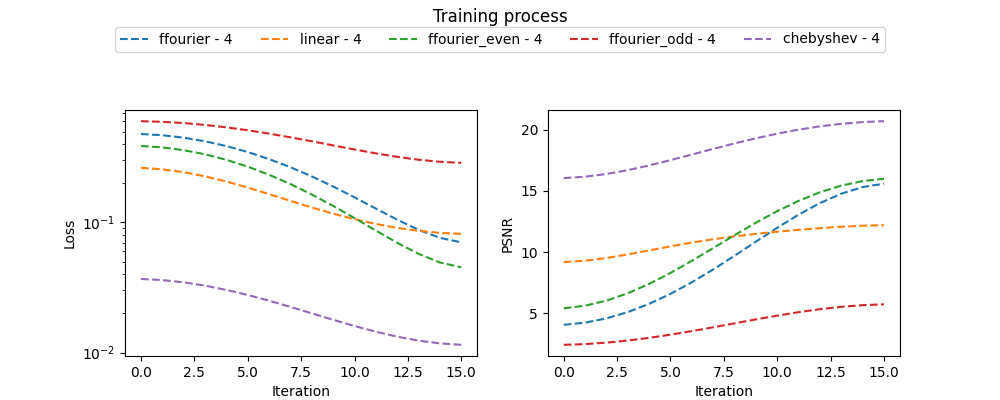

In [14]:
fig, axis = plt.subplots(1,2, figsize = (10,4), sharey = False, squeeze= False)

for i, basisFunction in enumerate(basisFunctions):
    for j, basisTerm in enumerate(basisTerms):
        subDatabase = database[(database['basisFunctions'] == basisFunction) & (database['basisTerms'] == basisTerm)]
        # subDatabase = subDatabase[subDatabase['dimension'] == 3]

        iters = subDatabase['iteration']
        losses = subDatabase['losses']
        psnrs = subDatabase['psnrs']

        losses = gaussian_filter1d(losses, sigma = 5)
        psnrs = gaussian_filter1d(psnrs, sigma = 5)

        axis[0,0].plot(iters, losses, label = f'{basisFunction} - {basisTerm}', color = hues[i], ls = linestyles[j])
        axis[0,1].plot(iters, psnrs, label = f'{basisFunction} - {basisTerm}', color = hues[i], ls = linestyles[j])

axis[0,0].set_yscale('log')
axis[0,0].set_xlabel('Iteration')
axis[0,0].set_ylabel('Loss')
# axis[0,0].legend(ncol = 2)

axis[0,1].set_xlabel('Iteration')
axis[0,1].set_ylabel('PSNR')

handles, labels = axis[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol = 5,bbox_to_anchor=(0.5, 0.95))

fig.suptitle('Training process')
fig.subplots_adjust(top = 0.725)
# fig.bbox_inches = 'tight'

# fig.tight_layout()

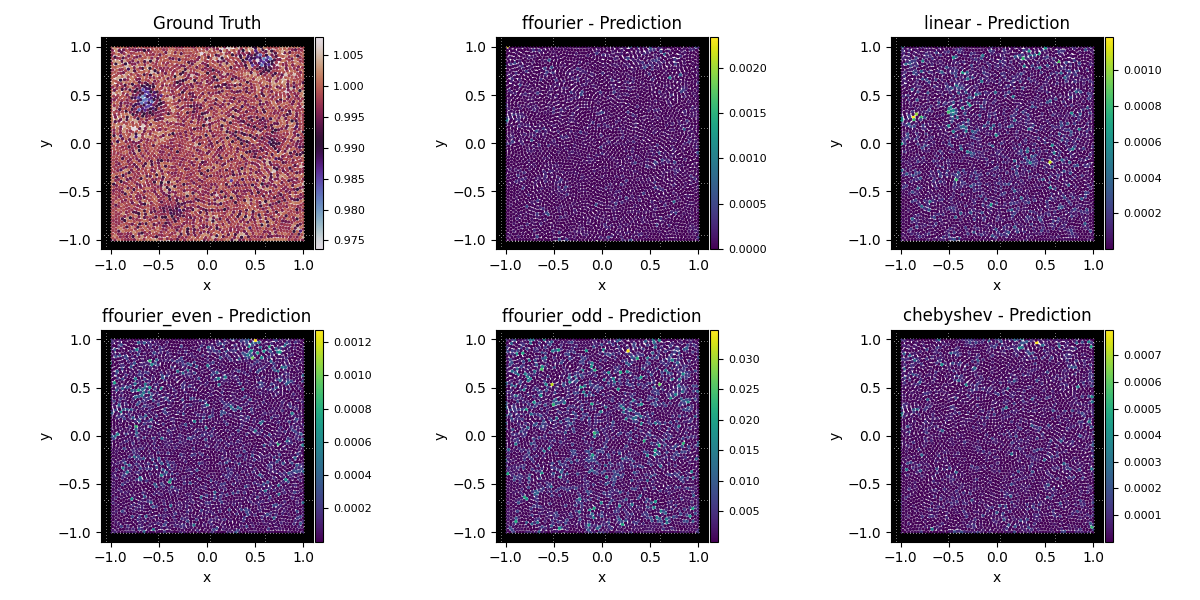

In [81]:

# config, attributes, currentState, priorState, trajectoryStates = loadAugmentedFrame(1052, train_ds, hyperParameterDict)
# # if currentState['fluid']['positions'].shape[1] == 2:
# deAugmentedState = augmentState(copy.deepcopy(currentState), augRotation = currentState['augmentRotation'].T if 'augmentRotation' in currentState else None, augmentFeatures=False)
# visualizationState = prepVisualizationState(deAugmentedState, config)


# fig, axis = plt.subplots(2,3, figsize = (12,6), sharey = False, squeeze= False)

# plotState = visualizeParticleQuantity(fig, axis[0,0], config, visualizationState, quantity = trajectoryStates[0]['fluid']['target'], mapping = '.x', s = s*4, 
#                             scaling = 'lin', gridVisualization=False, cmap = 'twilight', title = 'Ground Truth', plotBoth=True, which = 'fluid')

# for ax, model, basis in zip(axis.flatten()[1:], models, basisFunctions):

#     prediction = runInference(currentState, config, model, verbose = False)
#     loss = (prediction - trajectoryStates[0]['fluid']['target'])**2
#     plotState = visualizeParticleQuantity(fig, ax, config, visualizationState, quantity = loss, mapping = '.x', s = s*4, 
#                             scaling = 'lin', gridVisualization=False, cmap = 'viridis', title = f'{basis} - Prediction', plotBoth=True, which = 'fluid')


# for ax in axis.flatten():
#     ax.set_xlim(-1.1,1.1)
#     ax.set_ylim(-1.1,1.1)


# fig.tight_layout()

In [ ]:
from diffSPH.v2.plotting import prepVisualizationState, visualizeParticleQuantity, updatePlot

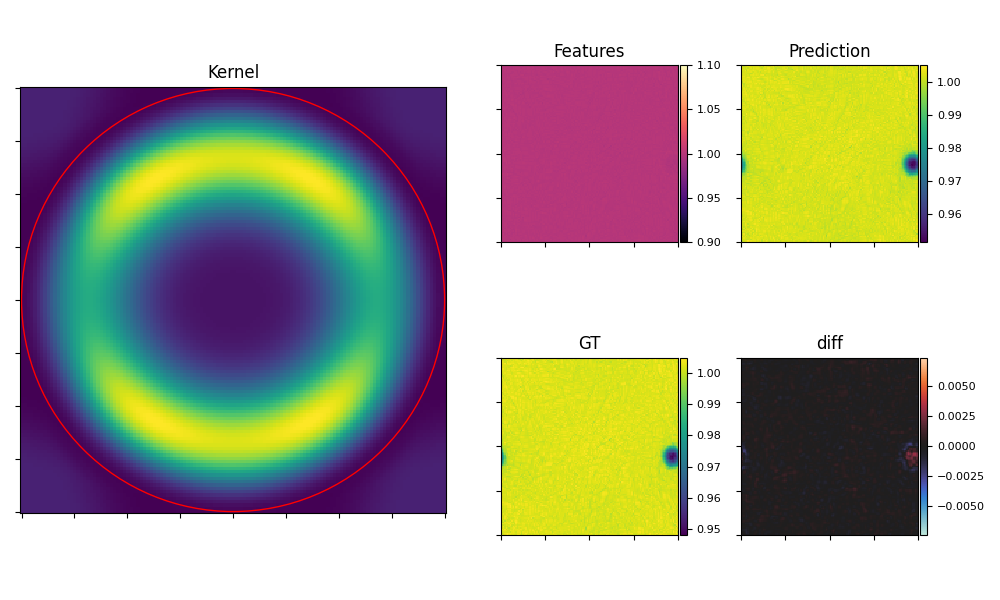

In [ ]:


deAugmentedState = augmentState(copy.deepcopy(currentState), augRotation = currentState['augmentRotation'].T if 'augmentRotation' in currentState else None)
visualizationState = prepVisualizationState(currentState, config)

s = 0.5
fig, axis = plt.subplot_mosaic('''AABC
                               AADE''', figsize=(10,6), sharex = False, sharey = False)

featurePlot = visualizeParticleQuantity(fig, axis['B'], config, visualizationState, quantity = 'features', mapping = '.x', s = s, 
                          scaling = 'lin', gridVisualization=True, cmap = 'magma', title = 'Features')

predictionPlot = visualizeParticleQuantity(fig, axis['C'], config, visualizationState, quantity = prediction[:,0], mapping = '.x', s = s, 
                          scaling = 'lin', gridVisualization=True, cmap = 'viridis', title = 'Prediction')
groundTruthPlot = visualizeParticleQuantity(fig, axis['D'], config, visualizationState, quantity = gt, mapping = '.x', s = s, 
                          scaling = 'lin', gridVisualization=True, cmap = 'viridis', title = 'GT')

lossPlot = visualizeParticleQuantity(fig, axis['E'], config, visualizationState, quantity = prediction - gt, mapping = '.x', s = s, 
                          scaling = 'sym', gridVisualization=True, cmap = 'icefire', title = 'diff', midPoint=0.0)

nx = 128
xx = np.linspace(-1, 1, nx)
yy = np.linspace(-1, 1, nx)
X, Y = np.meshgrid(xx, yy)
positions = torch.tensor(np.stack([X.flatten(), Y.flatten()]).T, device = currentState['fluid']['positions'].device, dtype = currentState['fluid']['positions'].dtype)

centralPosition = torch.tensor([[0.0, 0.0]], device = currentState['fluid']['positions'].device, dtype = currentState['fluid']['positions'].dtype)

distances = (positions - centralPosition).norm(dim = 1).view(-1,1) * (positions - centralPosition)

synthetic_i = torch.arange(0, positions.shape[0], device = currentState['fluid']['positions'].device, dtype = torch.long).flatten()
synthetic_j = torch.zeros_like(synthetic_i)

synthetic_features = torch.ones(positions.shape[0], device = currentState['fluid']['positions'].device, dtype = currentState['fluid']['positions'].dtype).view(-1,1)

synthetic = model(synthetic_features, synthetic_i, synthetic_j, distances, verbose = False)

sc = axis['A'].pcolormesh(X, Y, synthetic[:,0].detach().cpu().numpy().reshape(nx, nx), cmap = 'viridis')
circle = plt.Circle((0, 0), 1, color='r', fill=False)
axis['A'].add_artist(circle)
axis['A'].set_aspect('equal')
axis['A'].set_title('Kernel')

for ax in axis.values():
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

fig.tight_layout()


In [ ]:
visualizationState = prepVisualizationState(currentState, config)

for i in (t:=tqdm(range(1024))):
    optimizer.zero_grad()
    prediction = runInference(currentState, config, model, verbose = False)
    gt = trajectoryStates[0]['fluid']['target']

    loss = torch.nn.functional.mse_loss(prediction, gt)
    loss.backward()
    optimizer.step()
    t.set_description(f'Loss: {loss.item():.4e}')
    if i % 32 == 0:
        updatePlot(featurePlot, visualizationState, 'features')
        updatePlot(predictionPlot, visualizationState, prediction[:,0])
        updatePlot(groundTruthPlot, visualizationState, gt)
        updatePlot(lossPlot, visualizationState, prediction - gt)

        synthetic = model(synthetic_features, synthetic_i, synthetic_j, distances, verbose = False)
        sc.set_array(synthetic[:,0].detach().cpu().numpy().reshape(nx, nx).flatten())

        fig.canvas.draw()
        fig.canvas.flush_events()
    t.set_description(f'Loss: {loss.item():.4e}')




  0%|          | 0/1024 [00:00<?, ?it/s]

In [ ]:
# train_ds = datasetLoader(processFolder(hyperParameterDict, '~/dev/diffSPH/generative/dataset_dfsph/export'))
config, attributes, currentState, priorState, trajectoryStates = loadAugmentedFrame(1024, train_ds, hyperParameterDict)

optimizer.zero_grad()
prediction = runInference(currentState, config, model, verbose = False)
gt = trajectoryStates[0]['fluid']['target']

loss = torch.nn.functional.mse_loss(prediction, gt)
# loss.backward()
# optimizer.step()

tensor(0.4854, grad_fn=<MseLossBackward0>)


In [ ]:

# print(synthetic)

In [ ]:
print(synthetic_i)
print(synthetic_j)
print(synthetic)

tensor([   0,    1,    2,  ..., 1021, 1022, 1023])
tensor([0, 0, 0,  ..., 0, 0, 0])
tensor([[ 0.0382],
        [ 0.0382],
        [ 0.0382],
        ...,
        [-0.0071],
        [-0.0071],
        [-0.0071]], grad_fn=<cutlassBackward>)


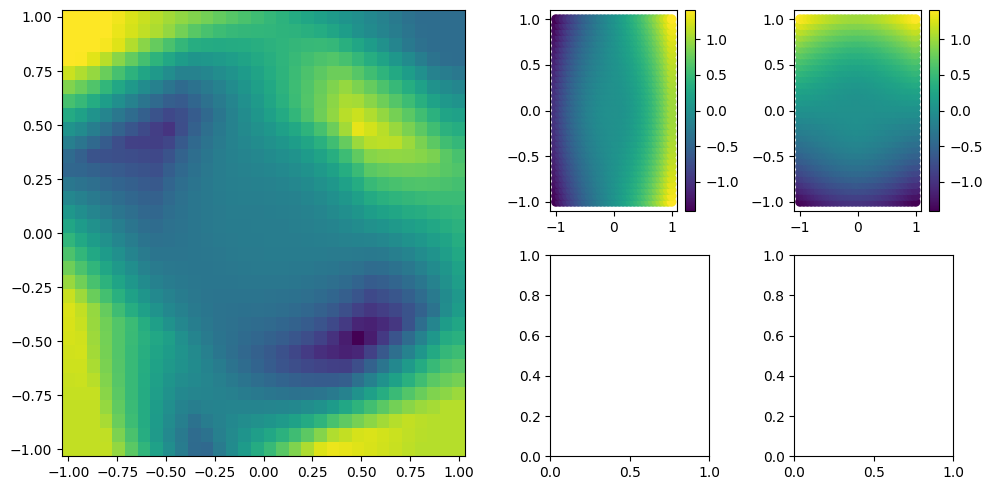

In [ ]:

fig, axis = plt.subplot_mosaic('''AABC
                               AADE''', figsize=(10,5), sharex = False, sharey = False)

# sc = axis['B'].imshow(distances[:,0].detach().cpu().numpy().reshape(16,16), cmap = 'viridis')
sc = axis['B'].scatter(positions[:,0].detach().cpu().numpy(), positions[:,1].detach().cpu().numpy(), c = distances[:,0].detach().cpu().numpy(), cmap = 'viridis')
fig.colorbar(sc, ax = axis['B'])
# sc = axis['C'].imshow(distances[:,1].detach().cpu().numpy().reshape(16,16), cmap = 'viridis')
sc = axis['C'].scatter(positions[:,0].detach().cpu().numpy(), positions[:,1].detach().cpu().numpy(), c = distances[:,1].detach().cpu().numpy(), cmap = 'viridis')
fig.colorbar(sc, ax = axis['C'])

sc = axis['A'].scatter(positions[:,0].detach().cpu().numpy(), positions[:,1].detach().cpu().numpy(), c = synthetic[:,0].detach().cpu().numpy(), cmap = 'viridis')

sc = axis['A'].pcolormesh(X, Y, synthetic[:,0].detach().cpu().numpy().reshape(nx, nx), cmap = 'viridis')

fig.tight_layout()

In [ ]:
    i, j = perennialState['fluid']['neighborhood']['indices']
    distances = perennialState['fluid']['neighborhood']['distances'].view(-1,1) * perennialState['fluid']['neighborhood']['vectors']
    return model(perennialState['fluid']['features'], i, j, distances, verbose = verbose)

In [ ]:
config['particle']['support']

0.059292720702474794

In [ ]:
currentState['fluid']['supports']

tensor([0.0593, 0.0593, 0.0593,  ..., 0.0593, 0.0593, 0.0593])

In [ ]:
# visualizationState

In [ ]:
config['kernel']

{'kernelScale': tensor(1.8974),
 'name': 'Wendland2',
 'targetNeighbors': 45.238956,
 'function': <diffSPH.kernels.KernelWrapper at 0x7e525f037c50>}

In [ ]:
from features import getFeatures

In [ ]:
searchNeighbors(priorState, config, True)

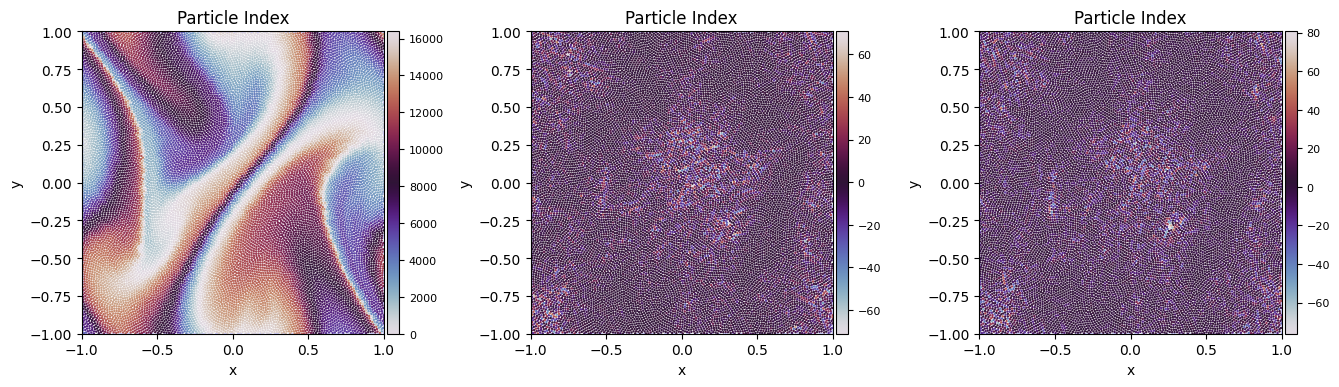

In [ ]:
import copy
from augment import augmentState
from diffSPH.v2.plotting import prepVisualizationState, visualizeParticleQuantity

# currentState['fluid']['features'] = getFeaturev2('attribute@rho / attribute@rho', currentState['fluid'], priorState['fluid'], config)
# currentState['fluid']['features'] = getFeatures(['attribute@u.x', 'attribute@u.y'], currentState['fluid'], priorState['fluid'], config)
# currentState['fluid']['features'] = getFeatures(['attribute:x*constant:-1'], currentState['fluid'], priorState['fluid'], config)

currentState['fluid']['features'] = getFeatures(['diff:compute[gradSym]:constant=1*attribute:rho'], currentState['fluid'], priorState['fluid'], config, currentState['time'] - priorState['time'])


deAugmentedState = augmentState(copy.deepcopy(currentState), augRotation = currentState['augmentRotation'].T if 'augmentRotation' in currentState else None)
visualizationState = prepVisualizationState(deAugmentedState, config)

s = 0.5
fig, axis = plt.subplot_mosaic('''ABC''', figsize=(13.5,5), sharex = False, sharey = False)

visualizeParticleQuantity(fig, axis['A'], config, visualizationState, quantity = 'indices', mapping = '.x', s = s, 
                          scaling = 'lin', gridVisualization=False, cmap = 'twilight', title = 'Particle Index')

visualizeParticleQuantity(fig, axis['B'], config, visualizationState, quantity = 'features', mapping = '.x', s = s, 
                          scaling = 'lin', gridVisualization=False, cmap = 'twilight', title = 'Particle Index')
visualizeParticleQuantity(fig, axis['C'], config, visualizationState, quantity = 'features', mapping = '.y', s = s, 
                          scaling = 'lin', gridVisualization=False, cmap = 'twilight', title = 'Particle Index')

fig.tight_layout()

In [ ]:
config['fluid']

{'cs': 20, 'mu': 0.1, 'rho0': 1000}

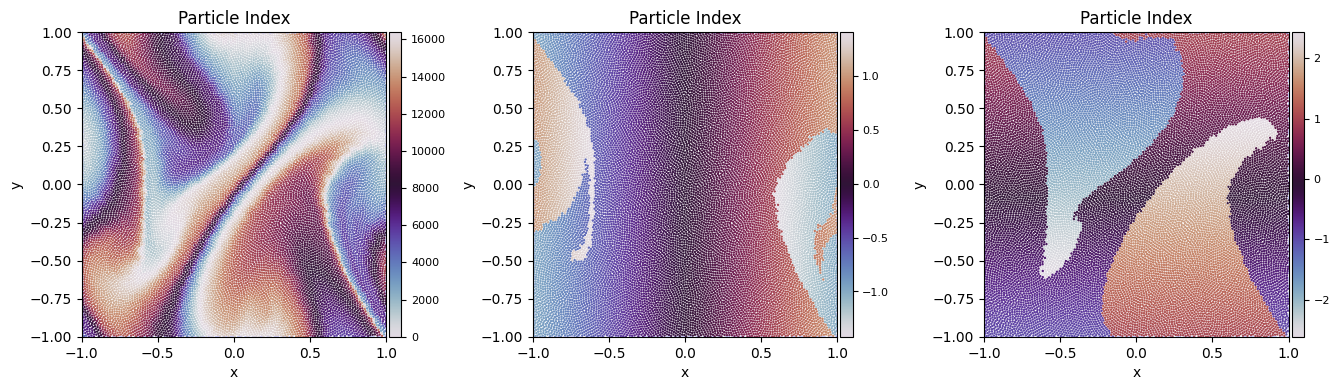